# Analyzing a Xenium dataset with the SPArrOW pipeline

In this notebook we will analyze a [Xenium](https://www.10xgenomics.com/platforms/xenium) dataset using the harpy pipeline.

## 1. Xenium platform

Xenium [instrument](https://www.10xgenomics.com/instruments/xenium-analyzer)

Xenium [workflow and on-board analysis](https://www.10xgenomics.com/support/software/xenium-onboard-analysis/latest/algorithms-overview/xoa-algorithms)

Xenium [gene panels](https://www.10xgenomics.com/products/xenium-panels#overview) overview

Xenium's new 5000-plex assay [Xenium Prime 5K](https://cdn.10xgenomics.com/image/upload/v1721239182/support-documents/CG000775_Prime5K_DataHighlightsTN_RevA_updated.pdf)

Xenium [multi modal cell segmentation](https://www.10xgenomics.com/support/in-situ-gene-expression/documentation/steps/assay/cell-segmentation-tech-note).


## 2. Dataset

We will explore 10x Genomics' public dataset [FFPE Human Lung Cancer with Xenium Multimodal Cell Segmentation](https://www.10xgenomics.com/datasets/preview-data-ffpe-human-lung-cancer-with-xenium-multimodal-cell-segmentation-1-standard). 

A summary of 10X's Xenium Onboard Analysis output on this dataset can be found [here](https://cf.10xgenomics.com/samples/xenium/2.0.0/Xenium_V1_humanLung_Cancer_FFPE/Xenium_V1_humanLung_Cancer_FFPE_analysis_summary.html). 

To better understand the dataset file, have a look at the [description](https://www.10xgenomics.com/support/software/xenium-onboard-analysis/latest/analysis) of the output files. Also [here](https://www.10xgenomics.com/support/software/xenium-explorer/latest/tutorials/inputs)

## 3. Read the data

In [ ]:
import harpy as hp

In [2]:
# Source data: https://www.10xgenomics.com/datasets/preview-data-ffpe-human-lung-cancer-with-xenium-multimodal-cell-segmentation-1-standard

import os
import pooch
from harpy.datasets.registry import get_registry

import tempfile
import uuid

path = None
#path = "/staging/leuven/stg_00143/spatial_data_training" # e.g. on HPC

OUTPUT_DIR =  tempfile.gettempdir()
# e.g. on HPC
#OUTPUT_DIR = "/staging/leuven/stg_00143/spatial_data_training/output_dir"

registry = get_registry( path = path ) # on Windows, set path (e.g. to r"c:\tmp")
path_unzipped = registry.fetch(
    "transcriptomics/xenium/Xenium_V1_humanLung_Cancer_FFPE/Xenium_V1_humanLung_Cancer_FFPE_outs.zip",  # Xenium output bundle
    processor=pooch.Unzip(extract_dir="."),
)
_ = registry.fetch(
    "transcriptomics/xenium/Xenium_V1_humanLung_Cancer_FFPE/Xenium_V1_humanLung_Cancer_FFPE_he_image.ome.tif"  # post-Xenium H&E stain
)
_ = registry.fetch(
    "transcriptomics/xenium/Xenium_V1_humanLung_Cancer_FFPE/Xenium_V1_humanLung_Cancer_FFPE_he_imagealignment.csv"  # H&E image alignment
)
input_path = os.path.commonpath(path_unzipped)

In [ ]:
OUTPUT_DIR =  tempfile.gettempdir()

sdata = hp.io.xenium(
    input_path,
    to_coordinate_system="global",
    aligned_images=True,
    cells_table=True,
    nucleus_labels=True,
    cells_labels=True,
    filter_gene_names=['Unassigned','NegControl'],
    output= os.path.join( OUTPUT_DIR, f"sdata_{uuid.uuid4()}.zarr" ),
)

In [ ]:
# or alternatively, read in spatialdata object from the registry
#from training_datasets import sdata_xenium

#sdata = sdata_xenium(path=path, output=os.path.join( OUTPUT_DIR, "sdata_xenium.zarr" ))

In [ ]:
sdata

## 4. Multi-model cell segmentation

The Xenium [protocol](https://www.10xgenomics.com/support/in-situ-gene-expression/documentation/steps/assay/xenium-in-situ-gene-expression-with-morphology-based-cell-segmentation-staining-user-guide) supports multi-modal cell segmentation using its cell segmentation staining kit.

The kit uses these 4 stains:
- DAPI: nuclear stain
- ATP1A1 / CD45 / E-Cadherin: membrane stains; clear boundaries for epithelial and immune cells
- 18S: 18S ribosomal RNA, labels the cytoplasm, pan-cell type marker
- AlphaSMA / Vimentin: interior protein staining; overlaps with 18S; not currently used by Xenium's onboard segmentation algorithm

Multi-model segmentation proceeds as follows:


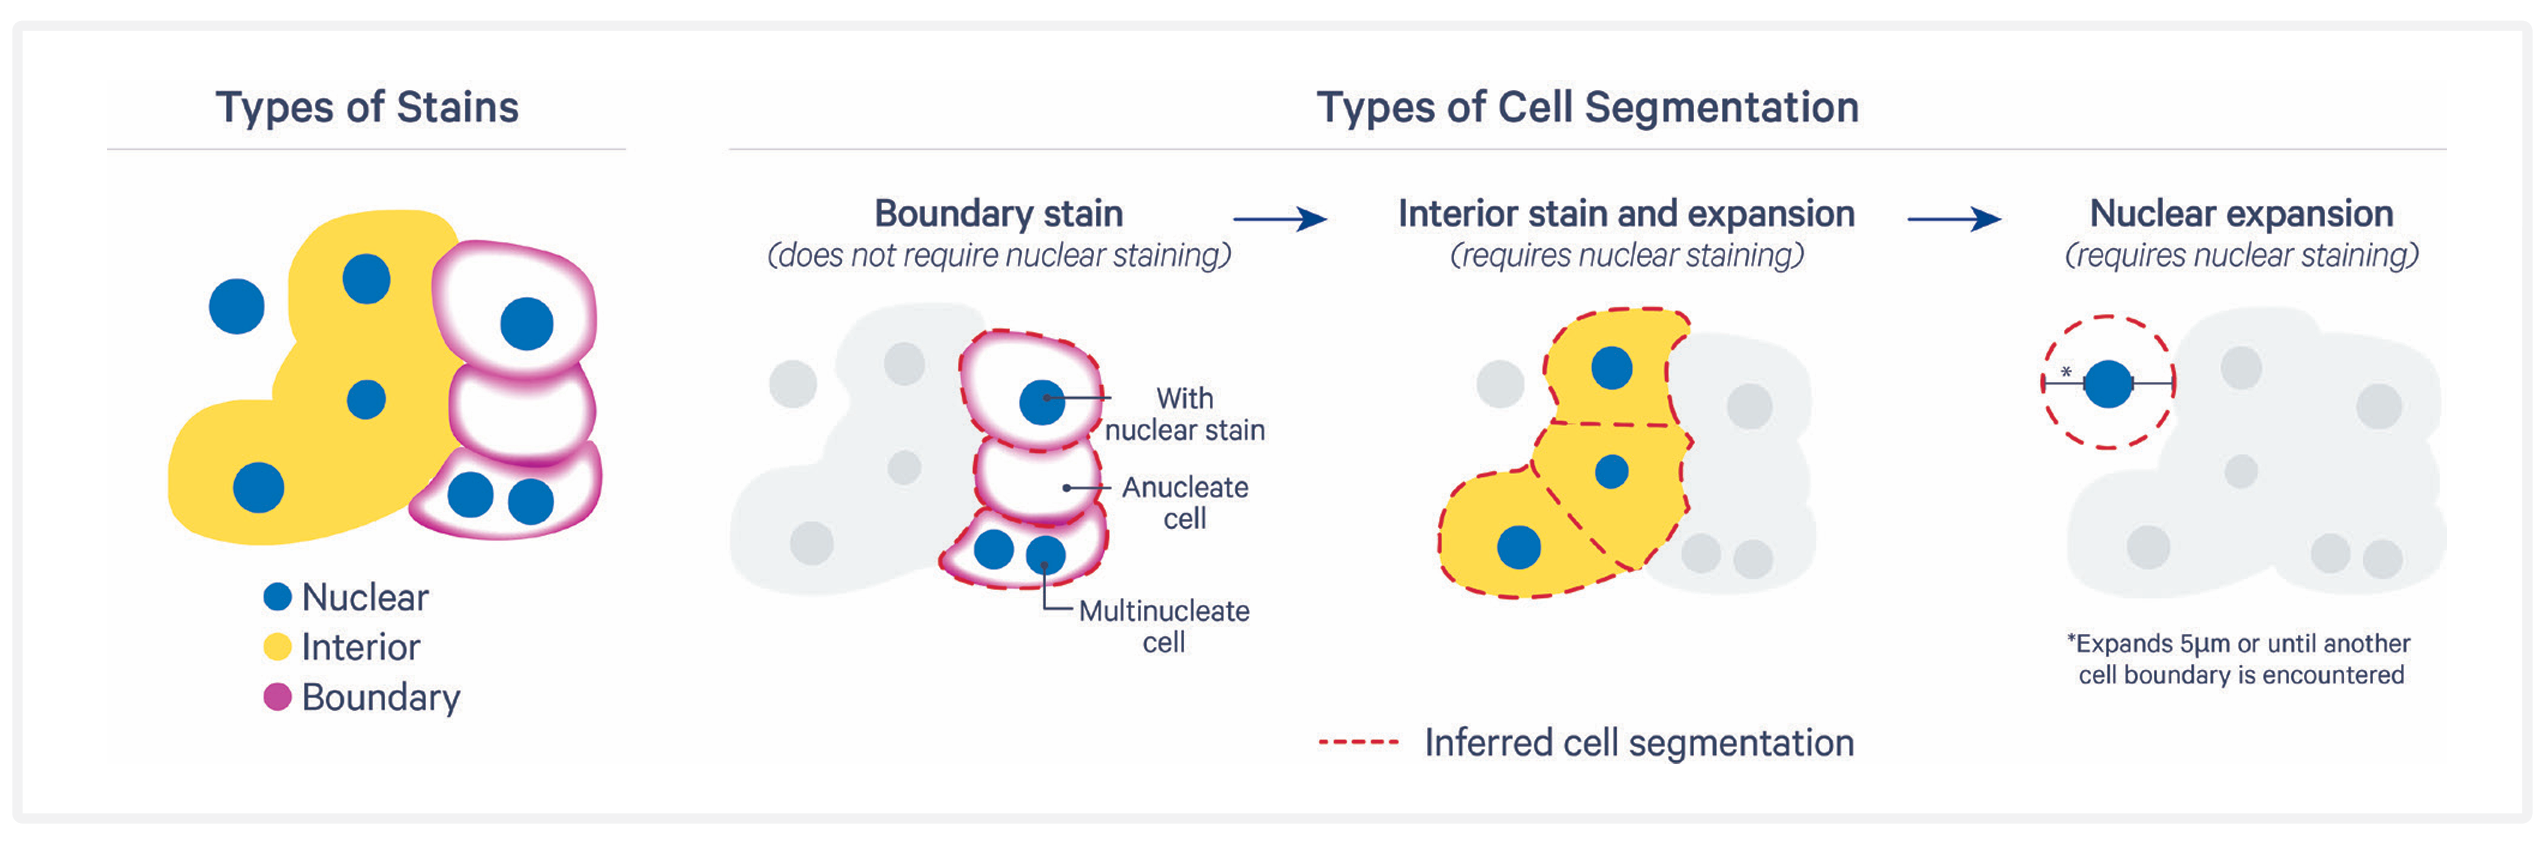

In [ ]:
# Show the channel names for Xenium's multi modal segmentation stains in "morphology_focus_global".

# We get the 4 staining channels listed above, in addition to a 5th "dummy" channel.
# This dummy channel is empty, and is a workaround to keep the spatialdata-napari plugin happy
# (otherwise it interprets the image as RGBA instead of multi-channel)

sdata['morphology_focus_global']["scale0"]["image"].c.data

Excercise:

- Use napari-spatialdata to visualize the image layer 'morphology_focus_global'.
- Next visualize the cell segmentation mask provided by Xenium, 'cell_labels_global'.
- Visualize the gene expression of 'ACE2'

In [ ]:
#from napari_spatialdata import Interactive

#Interactive( sdata )

## 5. Vectorize segmentation layer

We now vectorize the labels layer "cell_labels_global" which was output but the Xenium software.

In [ ]:
import dask

# Technical: vectorization uses rasterio (C library) so cannot use threading but should use processes (due to Python's GIL global interpreter lock)
# bottom line: asking dask to use processes is faster
with dask.config.set(scheduler="processes"):
    sdata = hp.sh.vectorize( sdata, labels_layer="cell_labels_global", output_layer="cell_labels_boundaries_global", overwrite=True )

In [ ]:
sdata[ "cell_labels_boundaries_global" ].head()

In [ ]:
# Plot Xenium's segmentation on top over its 4 stain images.
# left column: no shapes (None) over image,
# right column: shapes layer "cell_labels_boundaries_global" over image

hp.pl.plot_shapes(
    sdata,
    img_layer="morphology_focus_global",
    shapes_layer=[None, "cell_labels_boundaries_global"],  
    crd = [ 8000, 10000, 8000, 10000 ],
    channel= [ 'DAPI', 'ATP1A1/CD45/E-Cadherin', '18S', 'AlphaSMA/Vimentin' ],
    alpha = 0.4,
    linewidth=1.5,
      )

Excercise.

- Which spatial element annotates the table `table_global`?
- Can you visualize gene expression of gene `ACE2` using the sparrow function `hp.pl.plot_shapes`?

In [ ]:
# solution

from IPython.display import display

display( sdata[ "table_global" ] )

display( sdata[ "table_global" ].uns[ "spatialdata_attrs" ] )  # -> "region" = "cell_labels_global", which we vectorized to "cell_labels_boundaries_global" above

hp.pl.plot_shapes(
    sdata,
    img_layer="morphology_focus_global",
    shapes_layer="cell_labels_boundaries_global", # boundaries of table layer "cell_labels_global" obtained via hp.sh.vectorize(...)
    table_layer="table_global",
    column="ACE2",
    crd =[ 8000,10000, 8000, 10000 ],
    channel="DAPI",
    linewidth=0,
    figsize=(5,5),
      )

## 6. Image preprocessing

As we saw, the Xenium software outputs a useful cell segmentation, but we would like to compare it with segmentation obtained by CellPose using `SPArroW`. The first thing we do is image preprocessing. We do this on a crop.

The preprocessing steps are performed on all channels in the image layer.

In [ ]:
sdata = hp.im.min_max_filtering(
    sdata,
    img_layer="morphology_focus_global",
    output_layer="min_max_filtered",
    size_min_max_filter=51,   # specify a single value to be used for all channels, or specify a list with a value for each channel
    crd = [ 8000,10000,8000,10000 ],
    overwrite=True,
      )
sdata = hp.im.enhance_contrast(
    sdata,
    img_layer="min_max_filtered",
    output_layer="clahe",
    contrast_clip=3.5,        # specify a single value to be used for all channels, or specify a list with a value for each channel
    overwrite=True,
      )

In [ ]:
# Display the result of preprocessing the staining image channels
hp.pl.plot_image( sdata,
                 img_layer=[ "morphology_focus_global" , "clahe" ],
                 crd = [ 8000,10000,8000,10000 ],
                 channel= [ 'DAPI', 'ATP1A1/CD45/E-Cadherin', '18S', 'AlphaSMA/Vimentin' ] )

Excercise.

Change the parameters of the `SPArrOW` functions `hp.im.min_max_filtering` and `hp.im.enhance_contrast`, and see what the effect is on the resulting preprocessed image.

## 7. Cell segmentation

We will now segment the result of preprocessing, the "clahe" layer.
But in fact, CellPose's cyto3 model does a good job on the raw data, so it might be possible to skip preprocessing.

We will provide CellPose with the DAPI stained image, as well as the membrane stain ATP1A1/CD45/E-Cadherin. To make sure we provide the correct channel indices, we get them based on their channel names.

In [ ]:
from harpy.image._image import _get_spatial_element

# Image channels: array(['DAPI', 'ATP1A1/CD45/E-Cadherin', '18S', 'AlphaSMA/Vimentin', 'dummy'],

se = _get_spatial_element(sdata, layer="clahe")
channels = [ se.c.data.tolist().index("ATP1A1/CD45/E-Cadherin" ) + 1, 
             se.c.data.tolist().index("DAPI" ) + 1 ]                     #  + 1 because CellPose channel specifications are 1-indexed!!

channels  #  [membrane stain index + 1, nuclear stain index + 1]

In [ ]:
from dask.distributed import Client, LocalCluster

# # Create a local Dask cluster
cluster = LocalCluster(
     n_workers=8,              # Number of worker processes
     threads_per_worker=1,    # Number of threads per worker
     memory_limit="32GB",      # Memory limit per worker
 )

# # Connect a Client to the cluster
client = Client(cluster)

# # Print the Dask dashboard link
print(client.dashboard_link)

In [ ]:
import torch
from cellpose import models

from harpy.image import cellpose_callable

device = "cpu"  # mps broken in cellpose (macOS), see https://github.com/MouseLand/cellpose/issues/1063

sdata = hp.im.segment(
    sdata,
    img_layer="clahe",  # or "morphology_focus_global"
    chunks=2048,
    depth=200,
    model=cellpose_callable,
    # parameters that will be passed to the callable _cellpose
    pretrained_model = "cyto3",
    device = device,
    diameter=50,
    flow_threshold=0.9,
    cellprob_threshold=-4,
    channels=channels,
    output_labels_layer="segmentation_mask",
    output_shapes_layer="segmentation_mask_boundaries",
    crd= [8000, 10000, 8000, 10000],  # region to segment [x_min, xmax, y_min, y_max],
    overwrite=True,
)

client.close()

In [ ]:
# Compare Xenium multi-modal cell segmentation (left column) with CellPose cell segmentation (right column).
# The segmentation masks are drawn transparently over the 4 staining images.
hp.pl.plot_shapes(
    sdata,
    img_layer="morphology_focus_global",
    shapes_layer=[ "cell_labels_boundaries_global", "segmentation_mask_boundaries",],
    crd = [ 8000, 10000, 8000, 10000 ],
    channel= [ 'DAPI', 'ATP1A1/CD45/E-Cadherin', '18S', 'AlphaSMA/Vimentin' ],
    alpha = 0.4,
    linewidth=1.5,
      )

## 8. Transcript allocation

In principle we could skip this step, as the Xenium software does allocation too. It is provided in the table "table_global". 

However, we recommend recalculating the table using SPArrOW. See below for why.

In [ ]:
sdata = hp.tb.allocate(
    sdata=sdata,
    labels_layer="cell_labels_global", # we use the segmentation mask from Xenium, but we could also use CellPose segmentation masks in the layer "segmentation_mask"
    points_layer="transcripts_global",
    output_layer="table_global_redo",
    update_shapes_layers=False,
    overwrite=True,
)

# If you would like to remove some genes from the anndata table, you can still do it, uncomment the following code:

#adata = sdata[ "table_global_redo" ]

#pattern = 'Unassigned|NegControl'

#mask = ~adata.var.reset_index().astypes(str).apply(
#    lambda row: row.str.contains(pattern, case=False, na=False)
#).any(axis=1)

#sdata=hp.tb.add_table_layer( sdata, adata = adata[:, mask ].copy(), output_layer="table_global_redo", region=["cell_labels_global"], overwrite=True )

### 8.1 Comparing Xenium and SPArrOW allocation

In [ ]:
sdata[ "table_global" ]

In [ ]:
sdata[ "table_global_redo" ]

In [ ]:
sdata[ "table_global" ].obs.head()

In [ ]:
sdata[ "table_global_redo" ].obs.head()

In [ ]:
# Compare the number of transcripts allocated to the cell with ID 2, in the allocation done by Xenium versus the one done by SPArrOW
print(sdata[ "table_global_redo" ].X[0].sum())  # cell with cell_ID == 2 is at index 0 in table_global_redo (see dataframe above)
print(sdata[ "table_global" ].X[1].sum())       # cell with cell_ID == 2 is at index 1 in table_global (see dataframe above)

In [ ]:
# Show the counts for genes assigned to cell with ID 2 by SPArrOW
sdata[ "table_global_redo" ][ :, sdata[ "table_global_redo" ].X[0].toarray() !=0].to_df().iloc[0]

In [ ]:
# # Show the counts for genes assigned to cell with ID 2 by Xenium
sdata[ "table_global" ][ :, sdata[ "table_global" ].X[1].toarray() !=0].to_df().iloc[1]

For cell with `Cell_ID=2`, the count for PTPRC is 3 (see below). Using the `SPArrOW` function `hp.tb.allocate` this is correctly calculated, while table provided by Xenium only has count equal to 2 for PTPRC for cell with `cell_ID=2`.

Conclusion. We advice to recalculate the table layer.

In [ ]:
# Plot a close-up of the cell with ID 2, and the transcripts for gene PTPRC to confirm 
# that 3 transcripts are indeed inside this cell.
hp.pl.sanity(
    sdata,
    img_layer="morphology_focus_global",
    shapes_layer = "cell_labels_boundaries_global",
    points_layer= "transcripts_global",
    plot_cell_number=True,
    gene="PTPRC",
    crd = [ 947-50, 947.49+50, 8540-50, 8540+50 ],
    figsize=(5,5),
)

### 8.2 Exercise

Excercise:

Use segmentation mask generated by `SPArrOW`, and create the table layer.

In [ ]:
# solution

sdata = hp.tb.allocate(
    sdata=sdata,
    labels_layer="segmentation_mask",
    points_layer="transcripts_global",
    output_layer="table_transcriptomics",
    update_shapes_layers=False,
    overwrite=True,
)

In [ ]:
sdata[ "table_transcriptomics" ]

In [ ]:
from harpy.utils._keys import _REGION_KEY

sdata[ "table_transcriptomics" ].obs[ _REGION_KEY ].cat.categories.to_list()

In [ ]:
sdata[ "table_transcriptomics" ].to_df().head( 10 )

## 9. Transcript quality control

In [ ]:
# Calculate the transcript density.
sdata = hp.im.transcript_density(
    sdata,
    img_layer="morphology_focus_global",  # layer only used to extract image size information, so the transcript density can be plotted in the same image space
    points_layer="transcripts_global",
    output_layer="transcript_density",
    crd = [ 35000,52000,3000,20000 ],
    overwrite=True,
)

In [ ]:
# Plot the transcript density.
hp.pl.plot_image( sdata, img_layer= "transcript_density" , crd = [ 42000,50000,6000,12000 ] )

In [ ]:
# Also plot the DAPI image, so we can visually assess the relation between cell density and transcript density.
hp.pl.plot_image( sdata, img_layer= "morphology_focus_global" , crd = [ 42000,50000,6000,12000 ] , channel= "DAPI" )

What is the proportion of transcripts that could / could not be allocated to a cell?

In [ ]:
df = hp.pl.analyse_genes_left_out(
    sdata,
    labels_layer="segmentation_mask",
    table_layer="table_transcriptomics",
    points_layer="transcripts_global",
)

## 10. Preprocessing

In [ ]:
# Perform preprocessing.
sdata = hp.tb.preprocess_transcriptomics(
    sdata,
    labels_layer="segmentation_mask",
    table_layer="table_transcriptomics",
    output_layer="table_transcriptomics_preprocessed",  # write results to a new slot, we could also write to the same slot (when passing overwrite==True).
    min_counts=10,
    min_cells=5,
    size_norm=True,
    n_comps=50,
    overwrite=True,
    update_shapes_layers=False,
)

In [ ]:
sdata[ "table_transcriptomics" ]

In [ ]:
hp.pl.preprocess_transcriptomics(
    sdata,
    table_layer="table_transcriptomics_preprocessed",
)

In [ ]:
sdata[ "table_transcriptomics_preprocessed" ]

In [ ]:
sdata[ "table_transcriptomics" ].to_df().sum( axis=1 ).mean()  # mean total count per cell

In [ ]:
sdata[ "table_transcriptomics" ].to_df().sum( axis=1 ).std() # std total count per cell

In [ ]:
# Filter cells based on their size
sdata = hp.tb.filter_on_size(
    sdata,
    labels_layer="segmentation_mask",
    table_layer="table_transcriptomics_preprocessed",
    output_layer="table_transcriptomics_filter",
    min_size=500,
    max_size=100000,
    update_shapes_layers=False,
    overwrite=True,
)

## 11. Leiden Clustering

Excercise.

Use the `SPArrOW` function `hp.tb.leiden` to perform leiden clustering.

In [ ]:
# solution

import scanpy as sc

sdata = hp.tb.leiden(
    sdata,
    labels_layer="segmentation_mask",
    table_layer="table_transcriptomics_filter",
    output_layer="table_transcriptomics_clustered",
    calculate_umap=True,
    calculate_neighbors=True,
    n_pcs=17,
    n_neighbors=35,
    resolution=0.8,
    rank_genes=True,
    key_added="leiden",
    overwrite=True,
)

sc.pl.umap(sdata.tables["table_transcriptomics_clustered"], color=["leiden"], show=True)
sc.pl.rank_genes_groups(sdata.tables["table_transcriptomics_clustered"], n_genes=8, sharey=False, show=True)

In [ ]:
# Interactive(sdata)

In [ ]:
hp.pl.plot_shapes(
    sdata,
    img_layer="clahe",
    table_layer="table_transcriptomics_clustered",
    column="leiden",
    shapes_layer="segmentation_mask_boundaries",
    alpha=1,
    linewidth=0,
    channel="DAPI",
)

Let's at some details for a cell with a specific ID, for example cell_ID 321:

In [ ]:
# Boolean vector for selecting the desired cell(s):
is_cell_321 = sdata[ "table_transcriptomics_clustered"].obs[ "cell_ID" ] == 321

# Extract that cell's information from the observations dataframe'obs':
sdata[ "table_transcriptomics_clustered"].obs[ is_cell_321 ]

In [ ]:
# Get the cell's (x,y) location in image coordinates
sdata[ "table_transcriptomics_clustered"].obsm["spatial" ][ is_cell_321] # x y

This information matches what is shown in napari_spatialdata.

In [ ]:
# for new version of napari-spatialdata
#del sdata[ "table_transcriptomics_clustered"].uns[ "leiden_colors" ]

#Interactive( sdata )